Input Prompt: yellow triangle large
Predicted Color (RGB): [0.061594   0.81876725 0.3914324 ]
Predicted Shape: triangle
Predicted Size: 18.797626495361328


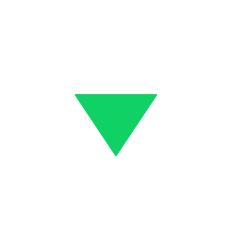

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Sample dataset with separate components for color, shape, and size
data = [
    ("red", "circle", "large"),  
    ("green", "square", "medium"),  
    ("blue", "triangle", "small"),  
    ("yellow", "circle", "small"),  
    ("purple", "square", "large"),  
    ("orange", "triangle", "medium")  
]

# Define vocabularies for color, shape, and size
color_vocab = {"red": 0, "green": 1, "blue": 2, "yellow": 3, "purple": 4, "orange": 5}
shape_vocab = {"circle": 0, "square": 1, "triangle": 2}
size_vocab = {"small": 0, "medium": 1, "large": 2}

# Define RGB values for colors, one-hot encoding for shapes, and numerical values for sizes
color_values = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 0], [0.5, 0, 0.5], [1, 0.5, 0]])
shape_labels = ["circle", "square", "triangle"]
size_values = np.array([20, 30, 40])  # Small, Medium, Large

# Model with separate pathways for color, shape, and size
class ShapeNetSeparate(nn.Module):
    def __init__(self):
        super(ShapeNetSeparate, self).__init__()
        
        # Embedding layers for each input component
        self.color_embedding = nn.Embedding(len(color_vocab), 8)
        self.shape_embedding = nn.Embedding(len(shape_vocab), 8)
        self.size_embedding = nn.Embedding(len(size_vocab), 8)
        
        # Processing layers for each component
        self.color_fc = nn.Sequential(nn.Linear(8, 16), nn.ReLU())
        self.shape_fc = nn.Sequential(nn.Linear(8, 16), nn.ReLU())
        self.size_fc = nn.Sequential(nn.Linear(8, 16), nn.ReLU())
        
        # Final layers combining all components
        self.fc_combined = nn.Linear(16 * 3, 16)
        self.fc3_color = nn.Linear(16, 3)  # RGB color prediction
        self.fc3_shape = nn.Linear(16, 3)  # Shape classification prediction
        self.fc3_size = nn.Linear(16, 1)   # Size prediction (continuous)

    def forward(self, color_input, shape_input, size_input):
        # Process each component independently
        color_feat = self.color_fc(self.color_embedding(color_input))
        shape_feat = self.shape_fc(self.shape_embedding(shape_input))
        size_feat = self.size_fc(self.size_embedding(size_input))
        
        # Concatenate features from each pathway
        combined_feat = torch.cat((color_feat, shape_feat, size_feat), dim=1)
        
        # Final processing and separate outputs
        x = torch.relu(self.fc_combined(combined_feat))
        color_output = torch.sigmoid(self.fc3_color(x))  # RGB output
        shape_output = self.fc3_shape(x)  # Shape classification
        size_output = self.fc3_size(x)  # Size output (regression)
        
        return color_output, shape_output, size_output

# Instantiate model, define loss functions, and optimizer
model = ShapeNetSeparate()
criterion_color = nn.MSELoss()
criterion_shape = nn.CrossEntropyLoss()
criterion_size = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Prepare training data as separate components
color_indices = torch.LongTensor([color_vocab[item[0]] for item in data])
shape_indices = torch.LongTensor([shape_vocab[item[1]] for item in data])
size_indices = torch.LongTensor([size_vocab[item[2]] for item in data])
color_targets = torch.FloatTensor(color_values)
shape_targets = torch.LongTensor([shape_vocab[item[1]] for item in data])
size_targets = torch.FloatTensor([size_values[size_vocab[item[2]]] for item in data]).view(-1, 1)

# Training loop
epochs = 3000
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Forward pass with separate inputs
    color_pred, shape_pred, size_pred = model(color_indices, shape_indices, size_indices)
    
    # Compute separate losses for each component
    loss_color = criterion_color(color_pred, color_targets)
    loss_shape = criterion_shape(shape_pred, shape_targets)
    loss_size = criterion_size(size_pred, size_targets)
    
    # Combined loss and backpropagation
    loss = loss_color + loss_shape + loss_size
    loss.backward()
    optimizer.step()
    
    # Print progress every 500 epochs
    if epoch % 500 == 0:
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')

# Function to parse prompt into model input
def parse_prompt(prompt):
    prompt = prompt.lower()
    color = next((word for word in color_vocab if word in prompt), None)
    shape = next((word for word in shape_vocab if word in prompt), None)
    size = next((word for word in size_vocab if word in prompt), None)
    if color and shape and size:
        color_input = torch.LongTensor([color_vocab[color]])
        shape_input = torch.LongTensor([shape_vocab[shape]])
        size_input = torch.LongTensor([size_vocab[size]])
        return color_input, shape_input, size_input
    else:
        raise ValueError("Prompt did not contain all necessary components (color, shape, and size).")

# Function to display the generated shape based on predictions
def generate_shape_from_predictions(color, shape, size):
    fig, ax = plt.subplots()
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.set_aspect('equal', 'box')
    ax.axis('off')

    if shape == 'circle':
        ax.add_patch(plt.Circle((50, 50), size, color=color))
    elif shape == 'square':
        ax.add_patch(plt.Rectangle((50 - size / 2, 50 - size / 2), size, size, color=color))
    elif shape == 'triangle':
        ax.add_patch(plt.Polygon([[50, 50 - size], [50 - size, 50 + size / 2], [50 + size, 50 + size / 2]], color=color))

    plt.show()

# Function to handle input and display output based on prompt
def generate_shape_from_prompt(prompt):
    try:
        color_input, shape_input, size_input = parse_prompt(prompt)
    except ValueError as e:
        print(f"Error: {e}")
        return
    
    # Make predictions
    color_pred, shape_pred, size_pred = model(color_input, shape_input, size_input)
    predicted_color = color_pred.detach().numpy().flatten()
    predicted_shape = shape_labels[shape_pred.argmax().item()]
    predicted_size = size_pred.item()

    # Display the prompt and predictions
    print(f"Input Prompt: {prompt}")
    print(f"Predicted Color (RGB): {predicted_color}")
    print(f"Predicted Shape: {predicted_shape}")
    print(f"Predicted Size: {predicted_size}")
    
    # Generate and display the shape based on predictions
    generate_shape_from_predictions(predicted_color, predicted_shape, predicted_size)

# Interactive widget for continuous input
def on_prompt_change(change):
    clear_output(wait=True)
    prompt = change['new']
    generate_shape_from_prompt(prompt)

# Create text input widget
prompt_input = widgets.Text(
    value='red circle large',
    placeholder='Enter a shape prompt...',
    description='Prompt:',
    disabled=False
)
prompt_input.observe(on_prompt_change, names='value')

# Display the widget
display(prompt_input)

Input Prompt: Draw a large green square
Predicted Color (RGB): [0.42868927 0.6169955  0.02586569]
Predicted Shape: square
Predicted Size: 34.52874755859375


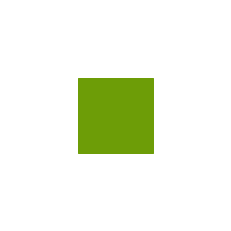

In [42]:
# Example prompt
generate_shape_from_prompt("Draw a large green square")

Color Accuracy: 59.26%
Shape Accuracy: 72.22%
Size Accuracy: 44.44%


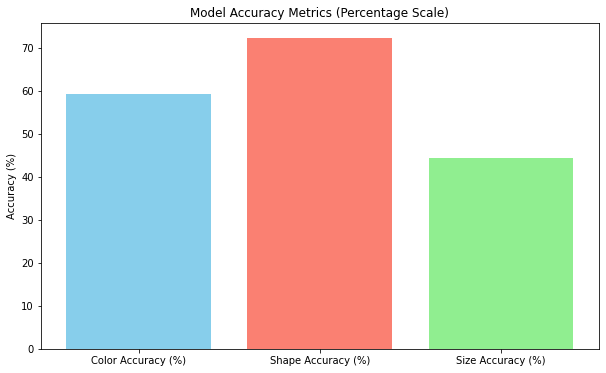

In [54]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define reasonable thresholds and ranges
color_error_threshold = 0.05  # MSE threshold for color within acceptable range
size_range = 50  # Total range of possible sizes for normalization
size_tolerance = 5  # Acceptable tolerance for size accuracy

# Define possible values for colors, shapes, and sizes
color_names = list(color_vocab.keys())
shape_names = list(shape_vocab.keys())
size_names = list(size_vocab.keys())

# Initialize counters for accuracy calculations
color_within_threshold = 0
shape_correct = 0
size_within_tolerance = 0

# Total number of samples
total_samples = len(color_names) * len(shape_names) * len(size_names)

# Generate and evaluate all combinations of color, shape, and size
for color in color_names:
    for shape in shape_names:
        for size in size_names:
            # Create a natural language prompt for the combination
            prompt = f"Draw a {size} {color} {shape}"
            
            # Parse the prompt to get model inputs
            color_input, shape_input, size_input = parse_prompt(prompt)
            
            # Get the true values for the combination
            true_color = color_values[color_vocab[color]]
            true_shape = shape
            true_size = size_values[size_vocab[size]]
            
            # Get model predictions
            color_pred, shape_pred, size_pred = model(color_input, shape_input, size_input)
            predicted_color = color_pred.detach().numpy()
            predicted_shape = shape_labels[shape_pred.argmax().item()]
            predicted_size = size_pred.item()
            
            # 1. Color Accuracy: Count predictions within the acceptable color error threshold
            color_mse = mean_squared_error(true_color, predicted_color.flatten())
            if color_mse <= color_error_threshold:
                color_within_threshold += 1
            
            # 2. Shape Accuracy: Count correct shape predictions
            if predicted_shape == true_shape:
                shape_correct += 1
            
            # 3. Size Accuracy: Count predictions within the acceptable size tolerance
            size_mae = mean_absolute_error([true_size], [predicted_size])
            if size_mae <= size_tolerance:
                size_within_tolerance += 1

# Calculate percentage accuracy for each attribute
color_accuracy = (color_within_threshold / total_samples) * 100
shape_accuracy = (shape_correct / total_samples) * 100
size_accuracy = (size_within_tolerance / total_samples) * 100

# Print overall accuracy metrics
print(f"Color Accuracy: {color_accuracy:.2f}%")
print(f"Shape Accuracy: {shape_accuracy:.2f}%")
print(f"Size Accuracy: {size_accuracy:.2f}%")

# Plot the accuracy metrics
metrics = ['Color Accuracy (%)', 'Shape Accuracy (%)', 'Size Accuracy (%)']
values = [color_accuracy, shape_accuracy, size_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['skyblue', 'salmon', 'lightgreen'])
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Metrics (Percentage Scale)')
plt.show()

In [50]:
# Step 2: Generate a focused dataset for retraining.
# Let's assume the model had trouble with shape prediction. We create more examples to balance shapes.

# New dataset with expanded focused examples
focused_data = [
    # Circles
    ("red", "circle", "small"), ("green", "circle", "medium"), ("blue", "circle", "large"),
    ("yellow", "circle", "small"), ("purple", "circle", "medium"), ("orange", "circle", "large"),
    ("red", "circle", "large"), ("green", "circle", "small"), ("blue", "circle", "medium"),
    ("yellow", "circle", "large"), ("purple", "circle", "small"), ("orange", "circle", "medium"),

    # Squares
    ("red", "square", "small"), ("green", "square", "medium"), ("blue", "square", "large"),
    ("yellow", "square", "small"), ("purple", "square", "medium"), ("orange", "square", "large"),
    ("red", "square", "large"), ("green", "square", "small"), ("blue", "square", "medium"),
    ("yellow", "square", "large"), ("purple", "square", "small"), ("orange", "square", "medium"),

    # Triangles
    ("red", "triangle", "small"), ("green", "triangle", "medium"), ("blue", "triangle", "large"),
    ("yellow", "triangle", "small"), ("purple", "triangle", "medium"), ("orange", "triangle", "large"),
    ("red", "triangle", "large"), ("green", "triangle", "small"), ("blue", "triangle", "medium"),
    ("yellow", "triangle", "large"), ("purple", "triangle", "small"), ("orange", "triangle", "medium"),

    # Additional variations to further balance the dataset
    ("red", "circle", "small"), ("blue", "square", "large"), ("green", "triangle", "medium"),
    ("purple", "circle", "large"), ("yellow", "square", "medium"), ("orange", "triangle", "small"),
    ("blue", "circle", "medium"), ("red", "square", "medium"), ("yellow", "triangle", "large"),
    ("green", "circle", "large"), ("purple", "square", "small"), ("orange", "circle", "medium"),
    ("yellow", "triangle", "small"), ("blue", "circle", "large"), ("red", "square", "small"),
    ("purple", "triangle", "medium"), ("green", "square", "large"), ("orange", "circle", "small")
]

# Convert the focused data to tensor format for retraining
color_indices = torch.LongTensor([color_vocab[item[0]] for item in focused_data])
shape_indices = torch.LongTensor([shape_vocab[item[1]] for item in focused_data])
size_indices = torch.LongTensor([size_vocab[item[2]] for item in focused_data])

# Target values for color, shape, and size based on focused_data
color_targets = torch.FloatTensor([color_values[color_vocab[item[0]]] for item in focused_data])
shape_targets = torch.LongTensor([shape_vocab[item[1]] for item in focused_data])
size_targets = torch.FloatTensor([size_values[size_vocab[item[2]]] for item in focused_data]).view(-1, 1)

# Step 3: Fine-tune the model using the focused dataset
epochs = 4000  # Fewer epochs may be sufficient for fine-tuning
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Forward pass with separate inputs for focused data
    color_pred, shape_pred, size_pred = model(color_indices, shape_indices, size_indices)
    
    # Calculate separate losses for each component
    loss_color = criterion_color(color_pred, color_targets)
    loss_shape = criterion_shape(shape_pred, shape_targets)
    loss_size = criterion_size(size_pred, size_targets)
    
    # Combine losses and backpropagate
    loss = loss_color + loss_shape + loss_size
    loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f'Retraining Epoch {epoch}/{epochs}, Loss: {loss.item()}')

Retraining Epoch 0/4000, Loss: 0.04882580414414406
Retraining Epoch 500/4000, Loss: 0.04785063490271568
Retraining Epoch 1000/4000, Loss: 0.04791801795363426
Retraining Epoch 1500/4000, Loss: 0.04784953594207764
Retraining Epoch 2000/4000, Loss: 0.047852639108896255
Retraining Epoch 2500/4000, Loss: 0.04860513284802437
Retraining Epoch 3000/4000, Loss: 0.047849077731370926
Retraining Epoch 3500/4000, Loss: 0.0479053258895874


Color Accuracy: 83.33%
Shape Accuracy: 100.00%
Size Accuracy: 100.00%


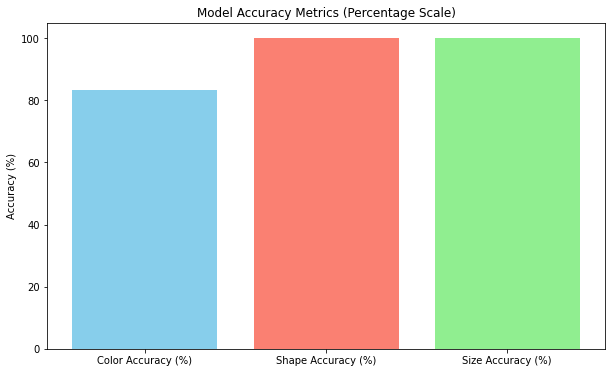

In [51]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define reasonable thresholds and ranges
color_error_threshold = 0.05  # MSE threshold for color within acceptable range
size_range = 50  # Total range of possible sizes for normalization
size_tolerance = 5  # Acceptable tolerance for size accuracy

# Define possible values for colors, shapes, and sizes
color_names = list(color_vocab.keys())
shape_names = list(shape_vocab.keys())
size_names = list(size_vocab.keys())

# Initialize counters for accuracy calculations
color_within_threshold = 0
shape_correct = 0
size_within_tolerance = 0

# Total number of samples
total_samples = len(color_names) * len(shape_names) * len(size_names)

# Generate and evaluate all combinations of color, shape, and size
for color in color_names:
    for shape in shape_names:
        for size in size_names:
            # Create a natural language prompt for the combination
            prompt = f"Draw a {size} {color} {shape}"
            
            # Parse the prompt to get model inputs
            color_input, shape_input, size_input = parse_prompt(prompt)
            
            # Get the true values for the combination
            true_color = color_values[color_vocab[color]]
            true_shape = shape
            true_size = size_values[size_vocab[size]]
            
            # Get model predictions
            color_pred, shape_pred, size_pred = model(color_input, shape_input, size_input)
            predicted_color = color_pred.detach().numpy()
            predicted_shape = shape_labels[shape_pred.argmax().item()]
            predicted_size = size_pred.item()
            
            # 1. Color Accuracy: Count predictions within the acceptable color error threshold
            color_mse = mean_squared_error(true_color, predicted_color.flatten())
            if color_mse <= color_error_threshold:
                color_within_threshold += 1
            
            # 2. Shape Accuracy: Count correct shape predictions
            if predicted_shape == true_shape:
                shape_correct += 1
            
            # 3. Size Accuracy: Count predictions within the acceptable size tolerance
            size_mae = mean_absolute_error([true_size], [predicted_size])
            if size_mae <= size_tolerance:
                size_within_tolerance += 1

# Calculate percentage accuracy for each attribute
color_accuracy = (color_within_threshold / total_samples) * 100
shape_accuracy = (shape_correct / total_samples) * 100
size_accuracy = (size_within_tolerance / total_samples) * 100

# Print overall accuracy metrics
print(f"Color Accuracy: {color_accuracy:.2f}%")
print(f"Shape Accuracy: {shape_accuracy:.2f}%")
print(f"Size Accuracy: {size_accuracy:.2f}%")

# Plot the accuracy metrics
metrics = ['Color Accuracy (%)', 'Shape Accuracy (%)', 'Size Accuracy (%)']
values = [color_accuracy, shape_accuracy, size_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['skyblue', 'salmon', 'lightgreen'])
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Metrics (Percentage Scale)')
plt.show()

Input Prompt: Please draw a medium green triangle
Predicted Color (RGB): [4.1624040e-05 9.5611221e-01 6.8547684e-01]
Predicted Shape: triangle
Predicted Size: 21.282148361206055


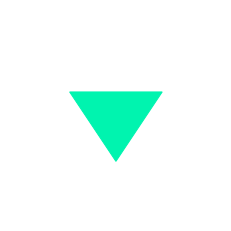

In [49]:
display(prompt_input)